In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, TweetTokenizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer


2023-04-12 11:42:29.319027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## PREPARING THE DATA

In [2]:
dataset = pd.read_csv('./IMDB Dataset.csv')

fraction = 0.1
dataset = dataset.sample(frac=fraction, random_state = 42).reset_index(drop=True)

# dataset = dataset.sample(frac=1, random_state = 42).reset_index(drop=True)

train_fraction = 0.8
df_train = dataset.iloc[:int(train_fraction*len(dataset.index))]
df_val = dataset.iloc[int(train_fraction*len(dataset.index)):int((train_fraction + 0.1 )*len(dataset.index))]
df_test = dataset.iloc[int((train_fraction+0.1)*len(dataset.index)):]

print("Train shape: ", df_train.shape)
print("Val shape: ", df_val.shape)
print("Test shape: ", df_test.shape)


Train shape:  (4000, 2)
Val shape:  (500, 2)
Test shape:  (500, 2)


In [3]:
def tokenize(text):
    tokens = nltk.tokenize.TweetTokenizer().tokenize(text)
    stemmer = PorterStemmer() # stemmer.
    stop_words = set(stopwords.words("english")) # the most common words
    new_text = [w.lower() for w in tokens] # tokenize each sentence and lower all the words
    new_text = [w for w in new_text if bool(re.search(r'\d', w)) == False] #remove any word containing a number
    new_text = [re.sub(r'[^\w\s]','',w) for w in new_text] # remove punctuation
    new_text = [w for w in new_text if w not in stop_words] # remove most common stop words
    new_text = [stemmer.stem(w) for w in new_text if len(w)>3] # apply stemming on words that have at least 3 letters
    new_text = np.asarray(new_text)
    return new_text

In [4]:


def get_features_tf_idf(df_train, df_val, df_test):

    vectorizer = TfidfVectorizer(
        lowercase = False,
        strip_accents = 'ascii',
        tokenizer = tokenize,
        min_df = 10, 
        stop_words = 'english',
        norm = 'l2',
    )


    vectorizer.fit(df_train["review"].values)
    feature_names = vectorizer.get_feature_names_out()

    X_train = vectorizer.transform(df_train["review"].values).toarray()
    X_val = vectorizer.transform(df_val["review"].values).toarray()
    X_test = vectorizer.transform(df_test["review"].values).toarray()


    X_train = pd.DataFrame(X_train, columns=feature_names)
    X_val = pd.DataFrame(X_val, columns=feature_names)
    X_test = pd.DataFrame(X_test, columns=feature_names)


    return X_train, X_val, X_test, vectorizer

X_train, X_val, X_test, vectorizer = get_features_tf_idf(df_train, df_val, df_test)

/Users/danielc/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/danielc/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whate

In [5]:
print(len(vectorizer.vocabulary_))
print(vectorizer.vocabulary_)

4134
{'realli': 2927, 'like': 2145, 'look': 2175, 'overal': 2579, 'reason': 2930, 'best': 325, 'didnt': 1013, 'main': 2222, 'event': 1263, 'time': 3724, 'huge': 1791, 'strong': 3523, 'glad': 1547, 'chang': 571, 'terribl': 3675, 'everi': 1265, 'match': 2265, 'card': 524, 'razor': 2914, 'brother': 452, 'bodi': 384, 'michael': 2316, 'monster': 2376, 'guard': 1630, 'jerri': 1987, 'stuff': 3535, 'alway': 115, 'destroy': 996, 'took': 3745, 'giant': 1540, 'anoth': 143, 'smoke': 3359, 'defend': 948, 'world': 4090, 'titl': 3732, 'bore': 399, 'end': 1208, 'howev': 1789, 'deserv': 988, 'mani': 2235, 'televis': 3663, 'appeal': 159, 'quit': 2885, 'differ': 1016, 'kind': 2050, 'fan': 1348, 'know': 2060, 'year': 4118, 'male': 2230, 'femal': 1382, 'countri': 828, 'think': 3698, 'ador': 52, 'miniseri': 2338, 'element': 1181, 'charact': 575, 'driven': 1116, 'drama': 1099, 'australian': 233, 'soap': 3366, 'opera': 2554, 'episod': 1240, 'scienc': 3163, 'fact': 1328, 'fiction': 1387, 'money': 2370, 'stake'

In [6]:
def encode_label(df_train, df_val, df_test):
    # encode the labels
    y_train = df_train['sentiment'].replace({'positive': 1, 'negative': 0})
    y_val = df_val['sentiment'].replace({'positive': 1, 'negative': 0})
    y_test = df_test['sentiment'].replace({'positive': 1, 'negative': 0})

    y_train = np.asarray(y_train)
    y_val = np.asarray(y_val)
    y_test = np.asarray(y_test)

    return y_train, y_val, y_test

In [7]:
# X_train = np.asarray(X_train)
# X_val = np.asarray(X_val)
# X_test = np.asarray(X_test)

y_train, y_val, y_test = encode_label(df_train, df_val, df_test)
# y_train = df_train['sentiment'].to_numpy()
# y_val = df_val['sentiment'].to_numpy()

# store the vocabulary size, the number of documents and their length
vocab_size = len(vectorizer.vocabulary_)
documents_number = len(X_train)
documents_length = X_train.shape[1]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(vocab_size)
print(documents_number)
print(documents_length)

(4000, 4134)
(500, 4134)
(500, 4134)
4134
4000
4134


In [8]:
print(X_train)

      abandon  abil       abl  abomin  abort  abraham  abrupt  absenc  absent  \
0         0.0   0.0  0.000000     0.0    0.0      0.0     0.0     0.0     0.0   
1         0.0   0.0  0.067132     0.0    0.0      0.0     0.0     0.0     0.0   
2         0.0   0.0  0.000000     0.0    0.0      0.0     0.0     0.0     0.0   
3         0.0   0.0  0.000000     0.0    0.0      0.0     0.0     0.0     0.0   
4         0.0   0.0  0.000000     0.0    0.0      0.0     0.0     0.0     0.0   
...       ...   ...       ...     ...    ...      ...     ...     ...     ...   
3995      0.0   0.0  0.000000     0.0    0.0      0.0     0.0     0.0     0.0   
3996      0.0   0.0  0.000000     0.0    0.0      0.0     0.0     0.0     0.0   
3997      0.0   0.0  0.000000     0.0    0.0      0.0     0.0     0.0     0.0   
3998      0.0   0.0  0.000000     0.0    0.0      0.0     0.0     0.0     0.0   
3999      0.0   0.0  0.000000     0.0    0.0      0.0     0.0     0.0     0.0   

      absolut  ...  youd  y

## MODELING

In [ ]:
# The model used for embedded words, that did not perform better than the above one
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=documents_length), # embedded layer of input size equal to the length of the vocabulary
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)), # trains two LSTM models: the first one as it is (forward) and the second one reversed (backwards)   
  tf.keras.layers.Dense(1, activation='softmax') # output layer
])

In [9]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(256,input_shape = (documents_length,), activation='relu'), # Dense layer with 256 neurons
  tf.keras.layers.Dropout(0.2), # Dropout layer with 20% of neurons to drop
  # tf.keras.layers.Dense(256, activation='relu'), # Dense layer with 256 neurons
  # tf.keras.layers.Dense(128, activation='relu'), # Dense layer with 128 neurons

  tf.keras.layers.Dense(64, activation='relu'), # Dense layer with 64 neurons
  tf.keras.layers.Dropout(0.2), # Dropout layer with 20% of neurons to drop
  tf.keras.layers.Dense(1, activation='softmax') # Dense layer with 2 neurons
])

2023-04-12 11:43:30.541310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
optimizer = Adam(learning_rate=0.03) # optimizer + learning rate
model.compile(
    optimizer=optimizer, 
    loss = 'binary_crossentropy', # loss + metric
    metrics = ['accuracy']
              )

In [11]:
checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir) 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_dir + '/model.{epoch:05d}.hdf5'
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = os.path.join('logs'),  
    write_graph = True, 
    update_freq = 'epoch'
)

In [12]:
# best score on the validation set was obtained using 50 epochs and a batch_size of 32
history = model.fit(X_train, y_train,
    epochs = 10, batch_size = 256, initial_epoch = 0, verbose=1,
    callbacks=[checkpoint_callback, tensorboard_callback],
    validation_data=(X_val, y_val))

Epoch 1/10
16/16 [==============================] - 2s 36ms/step - loss: 0.5484 - accuracy: 0.5070 - val_loss: 0.3406 - val_accuracy: 0.4860
Epoch 2/10
16/16 [==============================] - 0s 22ms/step - loss: 0.1680 - accuracy: 0.5070 - val_loss: 0.4094 - val_accuracy: 0.4860
Epoch 3/10
16/16 [==============================] - 0s 21ms/step - loss: 0.0439 - accuracy: 0.5070 - val_loss: 0.7053 - val_accuracy: 0.4860
Epoch 4/10
16/16 [==============================] - 0s 22ms/step - loss: 0.0088 - accuracy: 0.5070 - val_loss: 1.0503 - val_accuracy: 0.4860
Epoch 5/10
16/16 [==============================] - 0s 22ms/step - loss: 0.0011 - accuracy: 0.5070 - val_loss: 1.1620 - val_accuracy: 0.4860
Epoch 6/10
16/16 [==============================] - 0s 22ms/step - loss: 9.4274e-04 - accuracy: 0.5070 - val_loss: 1.2863 - val_accuracy: 0.4860
Epoch 7/10
16/16 [==============================] - 0s 23ms/step - loss: 6.6861e-04 - accuracy: 0.5070 - val_loss: 1.4011 - val_accuracy: 0.4860
Epoch

In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1058560   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,075,073
Trainable params: 1,075,073
Non-trainable params: 0
_________________________________________________________________
None


## PLOTS

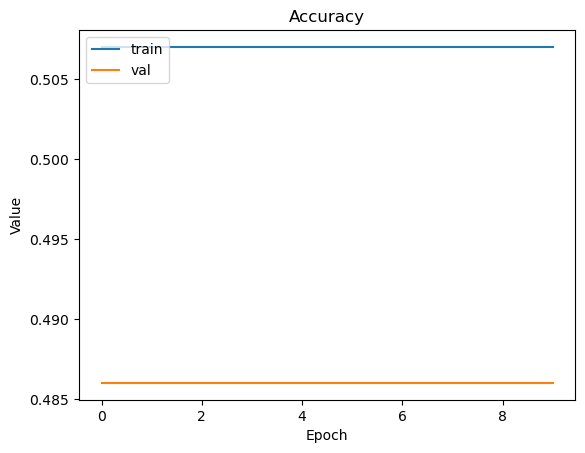

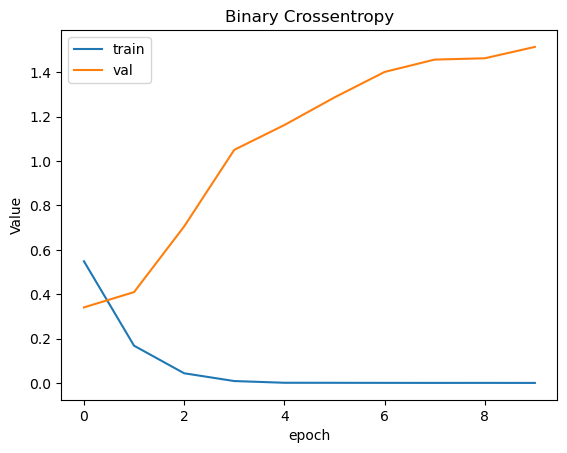

In [14]:
# plot the history of the model to observe it evolution for each epoch
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Accuracy')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Binary Crossentropy')
plt.ylabel('Value')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## EVALUATION

In [15]:
test_loss, test_metrics = model.evaluate(X_test, y_test, verbose=1) 
print('test loss binary crossentropy', test_loss)
print('test metrics accuracy', test_metrics)

16/16 [==============================] - 0s 3ms/step - loss: 1.7680 - accuracy: 0.4960
test loss binary crossentropy 1.767995834350586
test metrics accuracy 0.4959999918937683


In [16]:
# predict the target for the test set and format it according to the given standards
y_test_predicted = model.predict(X_test, verbose = 1)
y_test_predicted = pd.DataFrame(y_test_predicted)
y_test_output = pd.concat([y_test_predicted, pd.Series(y_test)], axis=1)
y_test_output.columns = ["prediction", 'ground_truth']
print(y_test_output)


16/16 [==============================] - 0s 2ms/step
     prediction  ground_truth
0           1.0             1
1           1.0             1
2           1.0             1
3           1.0             1
4           1.0             1
..          ...           ...
495         1.0             1
496         1.0             0
497         1.0             0
498         1.0             1
499         1.0             0

[500 rows x 2 columns]


In [17]:
from sklearn.metrics import classification_report

y_test_predicted = y_test_predicted.round() # print the classification report

print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       252
           1       0.50      1.00      0.66       248

    accuracy                           0.50       500
   macro avg       0.25      0.50      0.33       500
weighted avg       0.25      0.50      0.33       500



/Users/danielc/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danielc/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danielc/miniconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

## EXTRA MODEL

In [ ]:
# from xgboost import  XGBRegressor
# from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# model = MultiOutputRegressor(XGBRegressor(
#     n_estimators=100, # number of estimators that are to be used
#     max_depth=20, # maximum depth of a tree
#     learning_rate=0.1, 
#     verbosity=2, 
#     n_jobs=-1, # number of parralel multiprocessors
#     random_state = 42 # random seed
#     ),n_jobs=-1)

# model.fit(X_train, y_train)

# y_train_predicted = model.predict(X_train)
# score_train = model.score(X_train, y_train)
# print("\n\n============TRAIN============\n\n")
# print("R2 Score: {}".format(score_train))
# print("Mean Absolute Error: {}".format(mean_absolute_error(y_train, y_train_predicted)))
# print("Mean Squared Error: {}".format(mean_squared_error(y_train, y_train_predicted)))
# print("\n\n============VAL============\n\n")
# y_val_predicted = model.predict(X_val)
# score_val = model.score(X_val, y_val)
# print("R2 Score: {}".format(score_val))
# print("Mean Absolute Error: {}".format(mean_absolute_error(y_val, y_val_predicted)))
# print("Mean Squared Error: {}".format(mean_squared_error(y_val, y_val_predicted)))